## Load Processed Data

In [ ]:
import io
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

from src.terra.validate_onset import hourly_count, window_slice

TERRA_ZIP = "../data/raw/terra/ERC20-stablecoins.zip"
TERRA_INFO = "../data/processed/terra/terra_hourly_transfer_volume_by_contract.csv"
PRICE_ZIP = "../data/raw/terra/ERC20-stablecoins/price_data.zip"
PRICE_INFO = "../data/raw/terra/ERC20-stablecoins.zip"

In [28]:
with zipfile.ZipFile(TERRA_ZIP, "r") as outer:
    with outer.open("price_data.zip") as inner_file:
        with zipfile.ZipFile(inner_file) as inner:
            ustc_price = pd.read_csv(inner.open("price_data/ustc_price_data.csv"))

ustc_price.head()

ustc_price["datetime"] = pd.to_datetime(ustc_price["timestamp"], unit="s", utc=True)
ustc_price = ustc_price.sort_values("datetime").set_index("datetime")

In [30]:
TIME_COL = "datetime"
PRICE_COL = "close"

## Peg break detection (using close price)

In [37]:
from src.terra.peg_break import detect_peg_break_sustained, PegBreakRule

# Use close as the economic settlement price
ustc_price = ustc_price.copy()
ustc_price["datetime"] = pd.to_datetime(ustc_price["timestamp"], unit="s", utc=True)

rule = PegBreakRule(
    thr_low=0.995,
    thr_recover=0.998,
    sustain_hours=4,
    lookahead_hours=6
)

ustc_price_for_peg = ustc_price.drop(columns=["datetime"], errors="ignore").reset_index()

peg_break_time = detect_peg_break_sustained(
    ustc_price_for_peg,
    time_col="datetime",
    price_col="close",
    rule=rule
)
peg_break_time

if peg_break_time is not None:
    w = ustc_price.set_index("datetime").sort_index().loc[
        peg_break_time - pd.Timedelta(hours=6) : peg_break_time + pd.Timedelta(hours=12)
    ][["open","high","low","close"]]
    w


E:\Dab-a-thon\src\terra\peg_break.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  candidates = d.index[below & (~below.shift(1).fillna(False))]


## Load and Inspect the Dataset

In [9]:
df = pd.read_csv(TERRA_INFO)
df.head()

,token,timestamp,gross_transfer_volume,num_transfers
0,DAI,2022-04-01 11:00:00+00:00,2.174219e+07,333
1,DAI,2022-04-01 12:00:00+00:00,1.555625e+08,527
2,DAI,2022-04-01 13:00:00+00:00,8.395249e+07,563
3,DAI,2022-04-01 14:00:00+00:00,3.416577e+07,502
4,DAI,2022-04-01 15:00:00+00:00,2.886561e+07,540


## Focus on USTC (TerraUSD Classic)

In [10]:
ustc = df[df["token"] == "USTC"].copy()
ustc.head(), ustc.tail()

(    token                  timestamp  gross_transfer_volume  num_transfers
 119  USTC  2022-04-01 11:00:00+00:00           1.058221e+07             71
 120  USTC  2022-04-01 12:00:00+00:00           4.988686e+06             72
 121  USTC  2022-04-01 13:00:00+00:00           1.926639e+08            237
 122  USTC  2022-04-01 14:00:00+00:00           3.274675e+07            173
 123  USTC  2022-04-01 15:00:00+00:00           1.505007e+07            128,
     token                  timestamp  gross_transfer_volume  num_transfers
 144  USTC  2022-04-02 12:00:00+00:00           4.787258e+06            108
 145  USTC  2022-04-02 13:00:00+00:00           6.550568e+06            116
 146  USTC  2022-04-02 14:00:00+00:00           7.556280e+06            115
 147  USTC  2022-04-02 15:00:00+00:00           9.388636e+06            105
 148  USTC  2022-04-02 16:00:00+00:00           7.049479e+05             32)

## Sort and Prepare Time Series

In [11]:
ustc = ustc.sort_values("timestamp").reset_index(drop=True)

# Number of observations
n = len(ustc)

# Baseline = first 25% of the sample, with minimum of 6 hours
baseline_n = max(6, int(0.25 * n))

baseline = ustc.iloc[:baseline_n]

baseline_n, baseline["timestamp"].iloc[0], baseline["timestamp"].iloc[-1]

mu = baseline["gross_transfer_volume"].mean()
sigma = baseline["gross_transfer_volume"].std(ddof=0)

mu, sigma

(np.float64(40240551.0633467), 62752479.92132084)

In [12]:
if sigma == 0:
    sigma = 1.0

ustc["z_score"] = (
    ustc["gross_transfer_volume"] - mu
) / sigma

ustc[["timestamp", "gross_transfer_volume", "z_score"]].head()

,timestamp,gross_transfer_volume,z_score
0,2022-04-01 11:00:00+00:00,1.058221e+07,-0.472624
1,2022-04-01 12:00:00+00:00,4.988686e+06,-0.561761
2,2022-04-01 13:00:00+00:00,1.926639e+08,2.428962
3,2022-04-01 14:00:00+00:00,3.274675e+07,-0.119418
4,2022-04-01 15:00:00+00:00,1.505007e+07,-0.401426


In [13]:
# Panic definition parameters
z_thresh = 3.0   # how extreme
k = 3            # how persistent (hours)

ustc["is_extreme"] = ustc["z_score"] >= z_thresh
ustc["extreme_streak"] = ustc["is_extreme"].rolling(k).sum()

ustc[["timestamp", "z_score", "is_extreme", "extreme_streak"]].tail(10)

,timestamp,z_score,is_extreme,extreme_streak
20,2022-04-02 07:00:00+00:00,-0.617749,False,0.0
21,2022-04-02 08:00:00+00:00,0.476466,False,0.0
22,2022-04-02 09:00:00+00:00,-0.561819,False,0.0
23,2022-04-02 10:00:00+00:00,-0.322590,False,0.0
24,2022-04-02 11:00:00+00:00,-0.625495,False,0.0
25,2022-04-02 12:00:00+00:00,-0.564970,False,0.0
26,2022-04-02 13:00:00+00:00,-0.536871,False,0.0
27,2022-04-02 14:00:00+00:00,-0.520844,False,0.0
28,2022-04-02 15:00:00+00:00,-0.491645,False,0.0
29,2022-04-02 16:00:00+00:00,-0.630025,False,0.0


In [14]:
# First time the streak condition is met
candidates = ustc.index[ustc["extreme_streak"] >= k]

if len(candidates) == 0:
    print("No run onset found under current thresholds.")
    run_onset_time = None
else:
    onset_idx = candidates[0]
    run_onset_time = ustc.loc[onset_idx, "timestamp"]

run_onset_time


No run onset found under current thresholds.


In [15]:
lookahead_hours = 6   # Y
recover_z = 1.0       # define "back to normal"

if run_onset_time is None:
    print("No onset detected. Try lowering z_thresh or k.")
else:
    t0 = pd.to_datetime(run_onset_time, utc=True)
    window = ustc[(ustc["timestamp"] >= t0) & (ustc["timestamp"] <= t0 + pd.Timedelta(hours=lookahead_hours))]
    recovers = (window["z_score"].abs() < recover_z).any()

    if recovers:
        print("Detected spike recovers quickly → likely wobble. Increase k or z_thresh, or adjust baseline.")
    else:
        print("Onset passes non-recovery check → likely true panic onset.")


No onset detected. Try lowering z_thresh or k.


## Visual Overview - Full Time Series

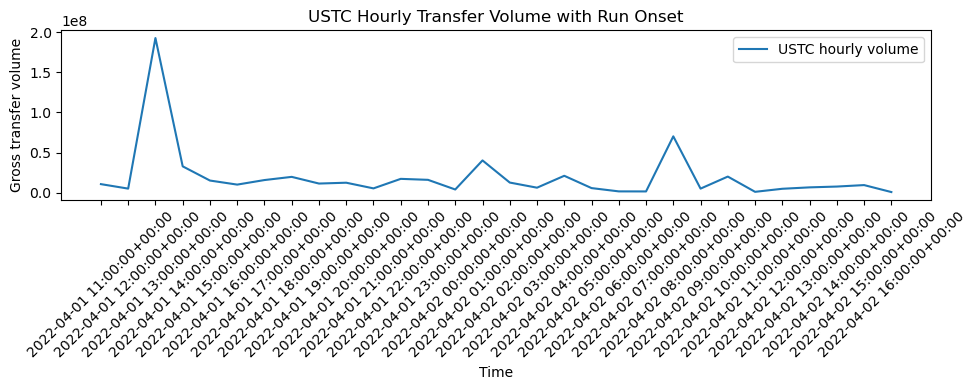

In [17]:
run_onset_time = pd.to_datetime(run_onset_time)


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(
    ustc["timestamp"],
    ustc["gross_transfer_volume"],
    label="USTC hourly volume"
)

if run_onset_time is not None:
    ax.axvline(run_onset_time, linestyle="--", color="black", label="Run onset")

ax.set_title("USTC Hourly Transfer Volume with Run Onset")
ax.set_xlabel("Time")
ax.set_ylabel("Gross transfer volume")
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
